In [66]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn
from tqdm import tqdm                  #this is used to detect infinite loops for debugging

In [67]:
'''
Class used as a template to implement BlackJack
Defination of state - (current sum, dealers showing, ace is usable?)
'''
class BlackJack:
    
    '''
    Constructor defines all the important parameters required to make an environment
    '''
    def __init__(self):
        
        #array to store all actions
        self.actions = [1,0]     #0-> stick, 1->hit
        
        #define player policy
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        #define dealer policy
        self.dealer_policy = np.ones(22, dtype=int)
        for i in range(17,22):
            self.dealer_policy[i] = self.actions[1]
        
    '''
    Function to generate Monte Carlo series by playing BlackJack game.
    This function has the option to start from a random state using the boolean parameter random_initial_state
    and also take a random action using parameter random_initial_action.
    Parameter onpolicy controlls whether we are using on-policy or off-policy methods (onpolicy = True imples on-policy method)
    '''
    def playGame(self, onpolicy = True, random_initial_state = False, random_initial_action = False):
        #generate initial state varaibles
        player_sum = 0
        dealer_sum = 0
        
        usable_player_ace = False
        usable_dealer_ace = False
        
        dealer_card1 = -1
        dealer_card2 = -1
        
        if not random_initial_state:
            
            #hit till the player sum reaches 12
            while(player_sum < 12):

                #selecting card 1-12 where 1-> Ace, 2-9 normal numbered cards, 10-12 are face cards
                #10-12 group is then brought down to 10 so that they can be used as their value
                card = min(random.randint(1,12), 10)

                #add card value to player_sum
                if(card == 1):
                    player_sum += 11
                else:
                    player_sum += card
                
                #initially if we have a sum greater than 21 then we must have two usable aces as the loop
                #terminates when player_sum >= 12
                if(player_sum > 21):
                    #there are two aces taking one as 1
                    player_sum-=10
                else:
                    # updating usable_player_ace using OR operator
                    usable_player_ace |= (card == 1)

            #dealer will show card1
            dealer_card1 = min(random.randint(1,12), 10)
            dealer_card2 = min(random.randint(1,12), 10)
        else:
            #generate a random initial state
            player_sum = random.randint(12,21)
            dealer_card1 = random.randint(1,10)
            usable_player_ace = bool(random.randint(0,1))
            dealer_card2 = min(random.randint(1,12), 10)
        
        #calculate the sum of cards for the dealer
        if(dealer_card1 == 1):
            dealer_sum += 11
        else:
            dealer_sum += dealer_card1
            
        if(dealer_card2 == 1):
            dealer_sum += 11
        else:
            dealer_sum += dealer_card2
            
        #set usable_dealer_ace to true accordingly
        usable_dealer_ace = (dealer_card1 == 1 or dealer_card2 == 1)
        
        #removing one usable ace if dealer busts
        if(dealer_sum > 21):
            #there are two aces taking one as 1
            dealer_sum-=10
            
        #create the state
        state = (player_sum, dealer_card1, usable_player_ace)
        
        #keep track of trajectory for MC series
        player_history = []
        
        # player starts playing...
        while(True):
            
            #if we have to take a random_initial_action we take it and then set the flag to False
            if(random_initial_action):
                action = np.random.choice(self.actions)
                random_initial_action = False
            elif not (onpolicy):
                #using behaviour policy as mentioned in the book
                if(random.random() < 0.5):
                    action = self.actions[0]
                else:
                    action = self.actions[1]
            else:
                #taking action using the player policy
                action = self.player_policy[player_sum]
            
            # update player history for MC series
            player_history.append([state, action])
            
            #if the player sticks break the current loop
            if(action == self.actions[1]):
                break
            
            # if the loop continues we have to hit
            # we hit using hit same method used to generate initial states
            card = min(random.randint(1,12), 10)
            
            #counting the number of aces the player has
            player_ace_count = int(usable_player_ace)
            
            if(card == 1):
                player_ace_count += 1
                player_sum += 11
            else:
                player_sum += card
                
            #Change usable aces to non usable aces to keep the player_sum below 21
            while(player_sum > 21 and player_ace_count != 0):
                player_sum -= 10
                player_ace_count -= 1
            
            #player busts and nothing can be done to save him
            if(player_sum > 21):
                return -1, player_history
            
            #if the number of aces is 1 we set usable ace to True
            #number of usable aces can't exceed 1 as then the player will bust
            usable_player_ace = (player_ace_count == 1)
            
        #Dealer's turn
        while(True):
            
            #dealer is taking aciton only based in the given policy
            action = self.dealer_policy[dealer_sum]
            
            #if the dealer sticks then break the loop
            if(action == self.actions[1]):
                break
                
            # if we didn't stick we have to hit
            # we hit using the same method used to generate initial states
            d_card = min(random.randint(1,12), 10)
            
            #initialise ace count for the dealer
            dealer_ace_count = int(usable_dealer_ace)
            
            # adding the card value to dealer_sum
            if(d_card == 1):
                dealer_ace_count += 1
                dealer_sum += 11
            else:
                dealer_sum += d_card
                
            # now we check for bust in the dealer_sum and try to prevent that by change value of aces to 1
            while(dealer_sum > 21 and dealer_ace_count != 0):
                dealer_sum -= 10
                dealer_ace_count -= 1
            
            # if the dealer still busts we return reward according to what is given in the question
            if(dealer_sum > 21):
                return 1, player_history
            usable_dealer_ace = (dealer_ace_count == 1)
            
        #if both the players stick then we decide who won based on their sum of cards
        if(player_sum > dealer_sum):
            return 1, player_history
        elif(player_sum == dealer_sum):
            return 0, player_history
        else:
            return -1, player_history
        
    def mc_onpolicy(self, episodes):
        #reseting player policy as some function update the player policy
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        #initialising arrays to store state values
        usable_ace = np.zeros((10,10))
        usable_ace_count = np.ones((10,10))
        
        usable_no_ace = np.zeros((10,10))
        usable_no_ace_count = np.ones((10,10))
        
        # running episodes and then updating state values to plot the data
        for i in range(episodes):
            reward, player_history = self.playGame(True)
            for (player_sum, dealer_card1, ace), action in player_history:
                player_sum -= 12
                dealer_card1 -= 1
                if(ace):
                    usable_ace[player_sum, dealer_card1] += reward
                    usable_ace_count[player_sum, dealer_card1] += 1
                else:
                    usable_no_ace[player_sum, dealer_card1] += reward
                    usable_no_ace_count[player_sum, dealer_card1] += 1
                    
        #returns average rewards
        return usable_ace/usable_ace_count, usable_no_ace/usable_no_ace_count
    
    def mc_exploring_starts(self, episodes):
        #reseting player policy as some function update the player policy
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        #the extra dimension is added for action to get action values
        action_value = np.zeros((10,10,2,2))
        action_value_count = np.ones((10,10,2,2))
        
        # running episodes and then updating state values to plot the data
        for i in range(episodes):
            reward, player_history = self.playGame(True, True, True)
            for (player_sum, dealer_card1, ace), action in player_history:
                ace = int(ace)
                player_sum-=12
                dealer_card1-=1
                action_value[player_sum, dealer_card1, ace, action] += reward
                action_value_count[player_sum, dealer_card1, ace, action] += 1
                
                # updating current policy by being greedy
                self.player_policy[player_sum + 12] = np.argmax(action_value[player_sum, dealer_card1, ace, :] / action_value_count[player_sum, dealer_card1, ace, :])
            
        # return average of action_values
        return action_value / action_value_count
                    
    def mc_offpolicy(self, episodes):
        #reseting player policy as some function update the player policy
        self.player_policy = np.ones(22, dtype=int)
        self.player_policy[20] = self.actions[1]
        self.player_policy[21] = self.actions[1]
        
        #initialise arrays to store importance sampling ratio (pho) and returns
        rho = np.ones(episodes)
        returns = np.zeros(episodes)
        
        #all the episodes and generate importance sampling ratio for all episodes
        for i in range(episodes):
            reward, player_history = self.playGame(False)
            for (player_sum, dealer_card1, ace), action in player_history:
                
                # if the target policy and behaviour policy give different actions then in this case target policy will give output 0
                # else we multiply by 2 which is equivalent to divding by behaviour policy which is equiprobable
                if(action == self.player_policy[player_sum]):
                    rho[i]*=2
                else:
                    rho[i] = 0
                    break
            returns[i] = reward
        
        # calculating importance sampling both ordinary and weighted
        weighted_returns = np.cumsum(rho*returns)
        rho = np.cumsum(rho)
        
        ordinary_sampling = weighted_returns / np.array(range(1,episodes+1,1))
        weighted_sampling = np.divide(weighted_returns, rho, out=np.zeros_like(weighted_returns), where=rho!=0)
        
        return ordinary_sampling, weighted_sampling
    
    '''
    This function generates Fig5.1. I have used an heatmap to represent 3D plot present in the book here the darker colours represent a higher value and a ligher
    colour represents a smaller value
    '''
    def generatefig51(self):
        usable_ace1, usable_no_ace1 = self.mc_onpolicy(10000)
        usable_ace2, usable_no_ace2 = self.mc_onpolicy(500000)
        
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        
        fig = seaborn.heatmap(usable_ace1[::-1], cmap="YlGnBu", ax=axes[0][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-0.6, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable Ace 10000")
        
        fig = seaborn.heatmap(usable_ace2[::-1], cmap="YlGnBu", ax=axes[0][1], xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-0.6, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable Ace 500000")
        
        fig = seaborn.heatmap(usable_no_ace1[::-1], cmap="YlGnBu", ax=axes[1][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-0.6, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable No Ace 10000")
        
        fig = seaborn.heatmap(usable_no_ace2[::-1], cmap="YlGnBu", ax=axes[1][1], xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-0.6, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Usable No Ace 500000")    
        
    '''
    This function generates Fig5.2. I have used an heatmap to represent 3D plot present in the book here the darker colours represent a higher value and a ligher
    colour represents a smaller value.
    For policy plot also heatmap is used but it uses darker colour to represent 1 that is hit and lighter to represent 0 which is stick
    '''
    def generatefig52(self):
        action_values = self.mc_exploring_starts(500000)
        
        # calculating final optimal values and policy
        usable_ace = np.max(action_values[:,:,0,:], axis=-1)
        usable_no_ace = np.max(action_values[:,:,1,:], axis=-1)
        
        policy_ace = np.argmax(action_values[:,:,0,:], axis=-1)
        policy_no_ace = np.argmax(action_values[:,:,1,:], axis=-1)
        
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        
        fig = seaborn.heatmap(policy_ace[::-1], cmap="YlGnBu",ax=axes[0][0], xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=0, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Policy with usable ace")
        
        fig = seaborn.heatmap(usable_ace[::-1], ax=axes[0][1], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-1, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Value with usable ace")
        
        fig = seaborn.heatmap(policy_no_ace[::-1], ax=axes[1][0], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=0, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Policy with non usable ace")
        
        fig = seaborn.heatmap(usable_no_ace[::-1], ax=axes[1][1], cmap="YlGnBu", xticklabels=range(1,11), yticklabels=range(12,22)[::-1], vmin=-1, vmax=1)
        fig.set_xlabel("Dealer Showing")
        fig.set_ylabel("Player Sum")
        fig.set_title("Optimal Value with non usable ace")
        
    '''
    This function generates fig5.3 and for that it used the weighted and ordinary importance sampling from mc_offploicy method and then
    calculates mean square error over 100 runs
    '''
    def generatefig53(self):
        #true value and number of episodes taken from the book
        value = -0.27726
        episodes = 10000
        
        ordinary_error = np.zeros(episodes)
        weighted_error = np.zeros(episodes)
        
        # calculated error in this loop
        for i in range(100):
            ordinary_sampling, weighted_sampling = self.mc_offpolicy(episodes)
            ordinary_error += (ordinary_sampling - value)**2
            weighted_error += (weighted_sampling - value)**2
        ordinary_error /= 100
        weighted_error /= 100
        
        plt.figure(figsize=(20,10))
        plt.plot(ordinary_error, label='Ordinary Importance Sampling')
        plt.plot(weighted_error, label='Weighted Importance Sampling')
        plt.xlabel('Episodes')
        plt.ylabel('MSE')
        plt.xscale("symlog")
        plt.legend()
        

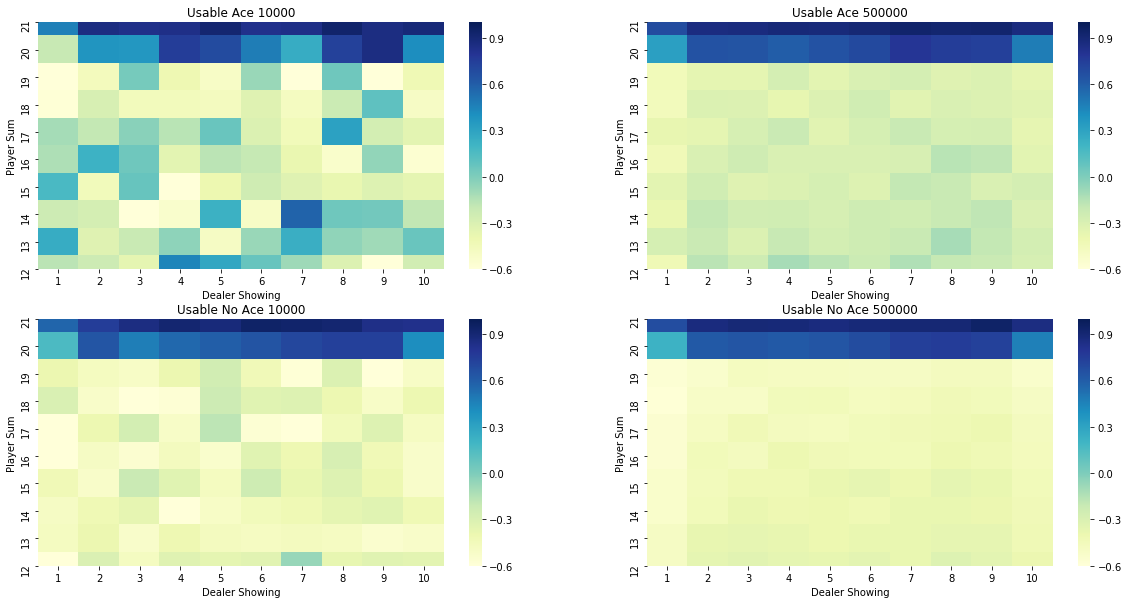

In [71]:
blackjack = BlackJack()
blackjack.generatefig51()

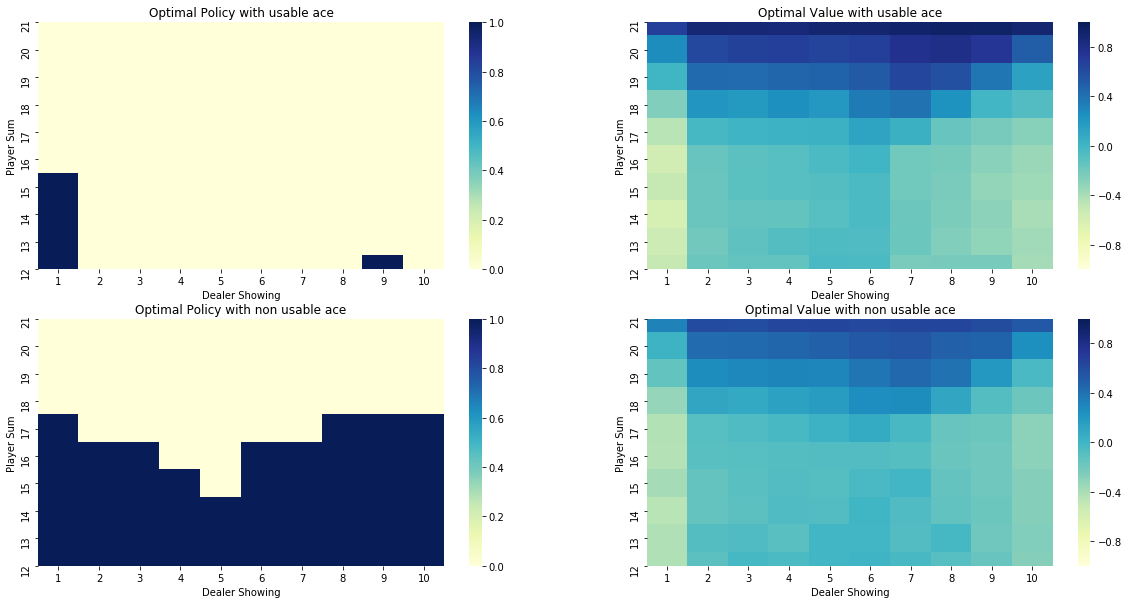

In [72]:
blackjack.generatefig52()

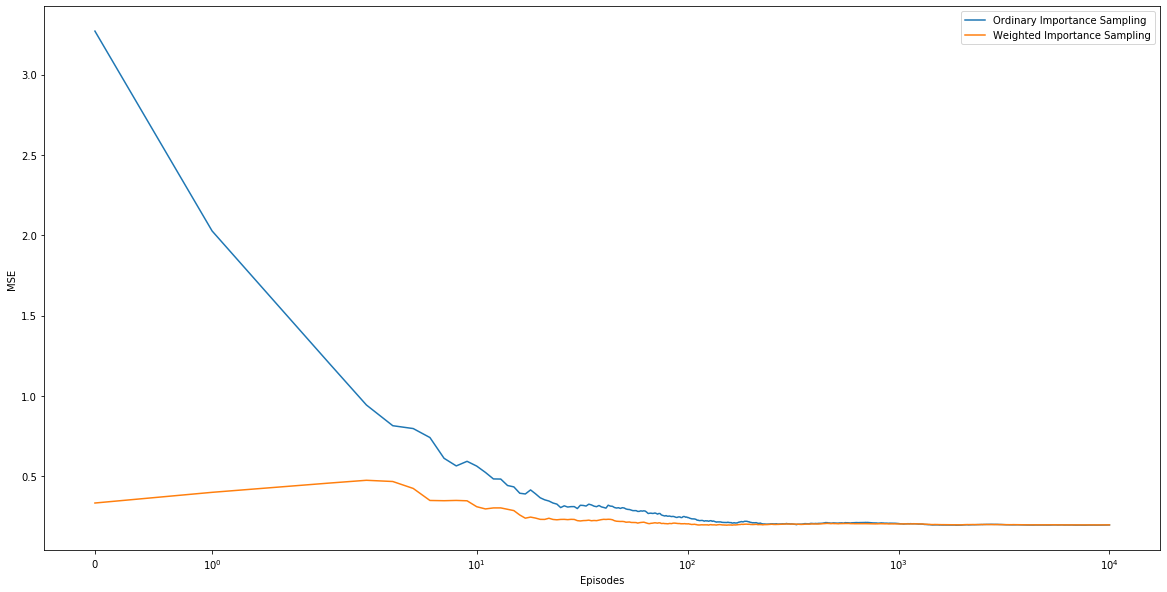

In [70]:
blackjack.generatefig53()